In [3]:
# Packages
import pandas as pd
#import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

import sys
import PyGRF

In [4]:
data_311 = pd.read_csv("../02 Data/modeling_grf.csv")
print(len(data_311))
data_311.head(7)

286


,Geography,lon,lat,his_num_311_per_property,neighbor_his_num_per_property,snow_depth,percent_below_poverty,percent_civilian_unemployed,per_capita_income,percent_no_highschool,...,percent_singleunits,percent_multiunit,percent_mobile_homes,percent_owneroccupiedunit,percent_crowding,percent_group_quarters,median_year_properties_built,median_value_properties_built,percent_no_vehicle,311_index_per_property
0,360290001101,1.082646e+06,1.033333e+06,26.511628,30.289854,150.887612,0.147147,0.025063,24233,0.113924,...,0.503125,0.000000,0.000000,0.804054,0.000000,0.007463,1926.0,84000.0,0.000000,10.697674
1,360290001102,1.082659e+06,1.035794e+06,22.717149,31.524310,144.951743,0.114962,0.121622,20756,0.053812,...,0.797546,0.000000,0.000000,0.702765,0.069124,0.000000,1930.0,84000.0,0.225806,6.458797
2,360290001103,1.077492e+06,1.036705e+06,46.311475,32.054695,138.311245,0.128906,0.035519,21980,0.136915,...,0.664251,0.000000,0.000000,0.540193,0.000000,0.000000,1910.0,63000.0,0.070740,11.065574
3,360290002001,1.082870e+06,1.041362e+06,42.962963,37.672279,141.764165,0.153184,0.194508,19691,0.190551,...,0.146789,0.000000,0.000000,0.356201,0.042216,0.005164,1920.0,76000.0,0.155673,7.777778
4,360290002002,1.082900e+06,1.038932e+06,28.082192,35.043359,142.996062,0.271845,0.108824,22876,0.019157,...,0.320755,0.000000,0.029650,0.314935,0.000000,0.000000,1910.0,77000.0,0.324675,11.986301
5,360290002003,1.082745e+06,1.037538e+06,21.261682,32.352120,142.236697,0.099608,0.009950,34223,0.040900,...,0.570815,0.091559,0.000000,0.520249,0.000000,0.010196,1925.0,78000.0,0.200935,5.841121
6,360290002004,1.082210e+06,1.039866e+06,29.518072,39.118877,142.071000,0.107573,0.029508,23291,0.217949,...,0.516129,0.000000,0.090726,0.376596,0.000000,0.000000,1925.0,68000.0,0.229787,9.036145


### bandwidth: 15, moran's I: 0.14163829762242533

In [5]:
# function for standarizing variables
def standarize_data(data, stats):
    return (data - stats['mean']) / stats['std']

In [6]:
# get columns for only dependent variables
data_311['Geography'] = data_311['Geography'].astype(str)
columns_to_exclude = ['Geography', 'lon', 'lat', '311_index_per_property']
X_columns = [column for column in data_311.columns if column not in columns_to_exclude]

y_predict = []
y_true = []
df_local_fi = pd.DataFrame()
df_global_fi = pd.DataFrame()
df_geo = pd.DataFrame()

K_fold = KFold(n_splits=10, shuffle=True, random_state=42)

i = 0
for train_index, test_index in K_fold.split(data_311):
    print(test_index)
    print("fold:", i)
    
    # get the training and test data in each fold
    X_train_all, X_test_all = data_311.iloc[train_index], data_311.iloc[test_index]
    y_train, y_test = X_train_all['311_index_per_property'], X_test_all['311_index_per_property']
    X_train = X_train_all[X_columns]
    X_test = X_test_all[X_columns]
    xy_coord = X_train_all[['lon', 'lat']]
    coords_test = X_test_all[['lon', 'lat']]

    # standarize dependent variables
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)

    # create a PyGRF model
    pygrf_311 = PyGRF.PyGRFBuilder(n_estimators=130, max_features=22, max_depth = 10, band_width=15, train_weighted=True, predict_weighted=True, bootstrap=True,
                          resampled=True, random_state=42)

    # fit the model and use it to make predictions
    pygrf_311.fit(X_scaled_train, y_train, xy_coord)

    y_train_pred_combined, y_train_pred_global, y_train_pred_local = pygrf_311.predict(X_scaled_train, xy_coord, local_weight=0.14163829762242533)
    r2_train = r2_score(y_train, y_train_pred_combined)

    predict_combined, predict_global, predict_local = pygrf_311.predict(X_scaled_test, coords_test, local_weight=0.14163829762242533)
    r2_test = r2_score(y_test, predict_combined)
    print(r2_test)

    # get the feature importance output by the local models
    local_fi = pygrf_311.get_local_feature_importance()
    local_fi['fid'] = i
    df_local_fi = pd.concat([df_local_fi, local_fi])
    
    global_fi = pygrf_311.global_model.feature_importances_
    df_global_fi = pd.concat([df_global_fi, pd.DataFrame(data=global_fi.reshape(1, -1), columns=X_columns)])

    X_train_geo = X_train_all['Geography']
    df_geo = pd.concat([df_geo, X_train_geo])

    y_predict = y_predict + predict_combined
    y_true = y_true + y_test.tolist()
    
    i = i + 1

[  5   9  33  45  56  73  79 109 111 124 143 146 155 170 185 196 200 212
 217 220 227 233 251 265 267 268 274 275 283]
fold: 0
0.48849093027447743


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  6  22  24  30  42  46  60  63  75  77  84  92  93 116 147 164 175 177
 181 193 203 204 207 211 221 234 240 249 269]
fold: 1
0.16647121683663146


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[ 10  15  16  18  19  25  37  66  67  68  82  86  90 112 113 117 120 125
 139 144 154 159 165 202 219 246 250 255 258]
fold: 2
0.38003295860864394


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  2  31  38  55  57  69  78  97 101 104 108 114 119 126 132 148 152 167
 173 184 206 218 224 232 254 264 272 277 281]
fold: 3
0.32462075228323706


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[ 12  29  35  65  74  76  85  96 107 115 118 127 137 140 157 158 168 172
 176 179 183 192 194 216 223 238 239 278 284]
fold: 4
0.26224732741214185


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  0  11  26  28  36  41  51  61  95  98 100 136 141 142 150 178 180 186
 195 210 215 225 226 231 242 256 263 266 279]
fold: 5
0.6394829241125558


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  4  23  27  32  40  44  62  64  70 122 123 128 135 138 153 156 162 182
 197 208 209 229 236 247 253 271 276 282]
fold: 6
0.1919857619142017


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  1   3  14  39  43  47  49  53  80  81  94 103 105 133 145 161 163 190
 199 201 213 222 230 237 244 245 248 261]
fold: 7
0.2827232913317834


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[  7   8  13  17  34  52  59  72  83  88  89  91 110 129 131 134 166 171
 198 205 228 241 243 259 260 262 273 280]
fold: 8
0.18526541726047074


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


[ 20  21  48  50  54  58  71  87  99 102 106 121 130 149 151 160 169 174
 187 188 189 191 214 235 252 257 270 285]
fold: 9
0.5601573533063172


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\PyGRF\PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


In [7]:
# compute the RMSE and r-square
rmse = mean_squared_error(y_true, y_predict, squared=False)
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse, 4)), "r2: " + str(round(r2, 5)))

rmse: 4.0136 r2: 0.43102


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
df_global_fi.reset_index(drop=True, inplace=True)
df_local_fi.reset_index(drop=True, inplace=True)
df_geo.reset_index(drop=True, inplace=True)

df_local_fi_1 = pd.merge(df_geo, df_local_fi, left_index=True, right_index=True, how="left")
del df_local_fi_1["model_index"]

attributes = df_local_fi_1.columns.difference(['Geography', 'fid'])

for i in range(len(df_global_fi)):
    df_local_fi_1_i = df_local_fi_1[df_local_fi_1["fid"] == i]
    
    for attribute in attributes:
        df_local_fi_1.loc[df_local_fi_1["fid"] == i, attribute] = (
            0.14163829762242533 * df_local_fi_1_i[attribute] + (1 - 0.14163829762242533) * df_global_fi[attribute][i]
        )

del df_local_fi_1["fid"]

geo_grouped = df_local_fi_1.groupby("Geography").mean().reset_index()
geo_grouped.head()

,Geography,his_num_311_per_property,neighbor_his_num_per_property,snow_depth,percent_below_poverty,percent_civilian_unemployed,per_capita_income,percent_no_highschool,percent_65older,percent_17younger,...,percent_notwell_english,percent_singleunits,percent_multiunit,percent_mobile_homes,percent_owneroccupiedunit,percent_crowding,percent_group_quarters,median_year_properties_built,median_value_properties_built,percent_no_vehicle
0,360290001101,0.371035,0.027595,0.033818,0.014655,0.019909,0.027327,0.021521,0.025773,0.032279,...,0.016164,0.044810,0.014091,0.009719,0.029815,0.005198,0.015195,0.046544,0.040291,0.043040
1,360290001102,0.367394,0.029250,0.032903,0.013657,0.019611,0.021064,0.020857,0.025388,0.022807,...,0.016080,0.078221,0.013740,0.018812,0.034643,0.004983,0.014507,0.045081,0.031376,0.021446
2,360290001103,0.375828,0.029096,0.031652,0.014698,0.022979,0.026585,0.023536,0.061348,0.020946,...,0.016283,0.031587,0.014268,0.007458,0.031107,0.005273,0.013700,0.059483,0.036683,0.022919
3,360290002001,0.376829,0.029571,0.039134,0.022219,0.019629,0.017332,0.024536,0.022879,0.020143,...,0.016050,0.018723,0.021605,0.002392,0.034232,0.005001,0.020511,0.090463,0.031717,0.034756
4,360290002002,0.381829,0.030178,0.043248,0.015125,0.020079,0.017907,0.041627,0.025476,0.022370,...,0.016619,0.039457,0.014458,0.010527,0.031539,0.005080,0.024712,0.046538,0.034864,0.025522


In [20]:
final_columns = ['historical 311 requests pp', 'nearby-CBG historical 311 requests pp', 'snow depth', 
                 '% poverty', '% unemployed',
                 'income', '% < highschool', '% age ≥ 65', 
                 '% age < 18', '% disability', 
                 '% single parent', '% minority', 
                 '% not well English', '% single-unit structure',
                '% multi-unit structure', '% mobile homes',
                '% owner-occupied housing units', '% crowding housing units',
                '% in group quarters', 'median year built', 'median property value', '% no vehicle available']

In [21]:
geo_grouped_1 = geo_grouped.set_index("Geography")
geo_grouped_1.columns = final_columns

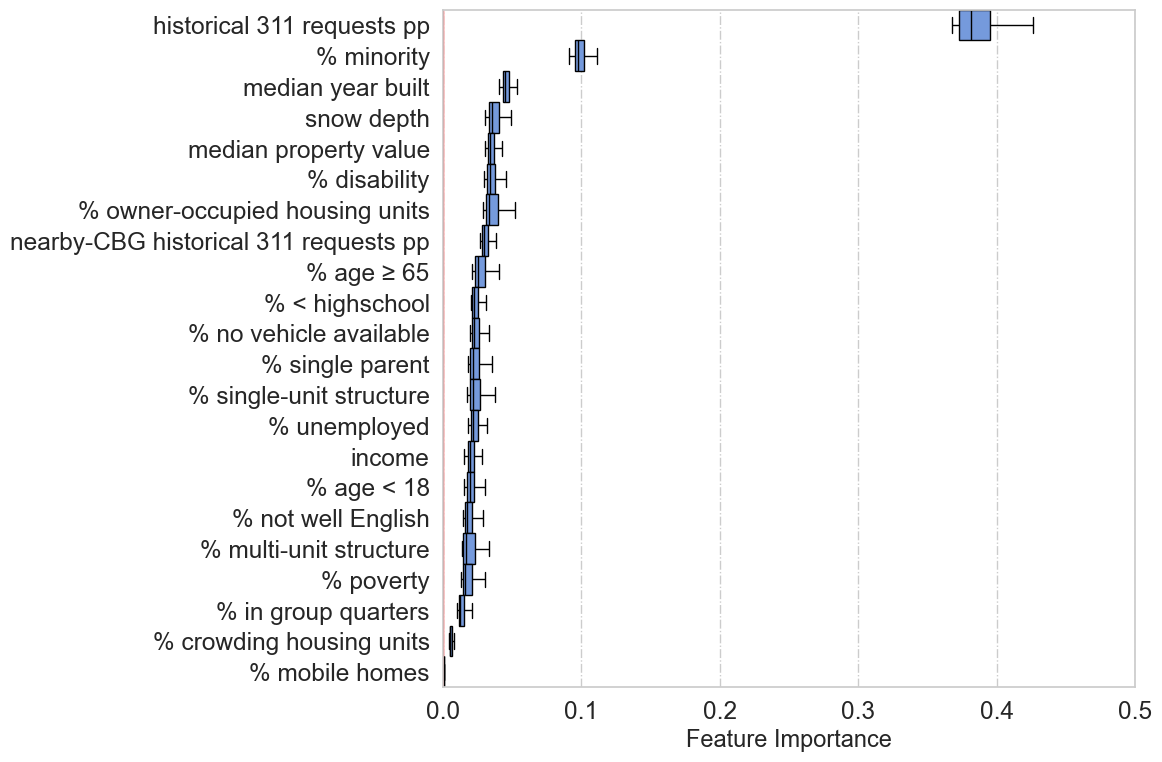

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",font_scale = 1.6)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

df_complete_feaimp_box = geo_grouped_1.copy()
index_sort = df_complete_feaimp_box.median().abs().sort_values(ascending=False).index
df_complete_feaimp_box = df_complete_feaimp_box[index_sort]

plt.axvline(x=0, color='red', linestyle='-', linewidth=1)

ax = sns.boxplot(data=df_complete_feaimp_box, orient='h', color = "cornflowerblue", showfliers = False, width=1,
            flierprops = dict(markerfacecolor = '0.5', markersize = 7.7, alpha = 0.5, markeredgecolor='white'),
            **PROPS) #palette="coolwarm_r"
plt.xlabel('Feature Importance', fontsize=17)
plt.ylabel('')
plt.xlim(0,0.5)
plt.grid(axis = 'x', linestyle='-.')

plt.tight_layout()
# plt.savefig("../03 Figures/GRF_feature_importance.png",dpi=300)